In [1]:
import pandas as pd
import numpy as np

In [134]:
csv_path = "bankloan.csv"
df = pd.read_csv(csv_path)
df.head()

ID  Age  Experience  Income  ZIP.Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal.Loan  Securities.Account  CD.Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [135]:
df = df.drop('ID',axis = 'columns')
df.head()

Age  Experience  Income  ZIP.Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Personal.Loan  Securities.Account  CD.Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

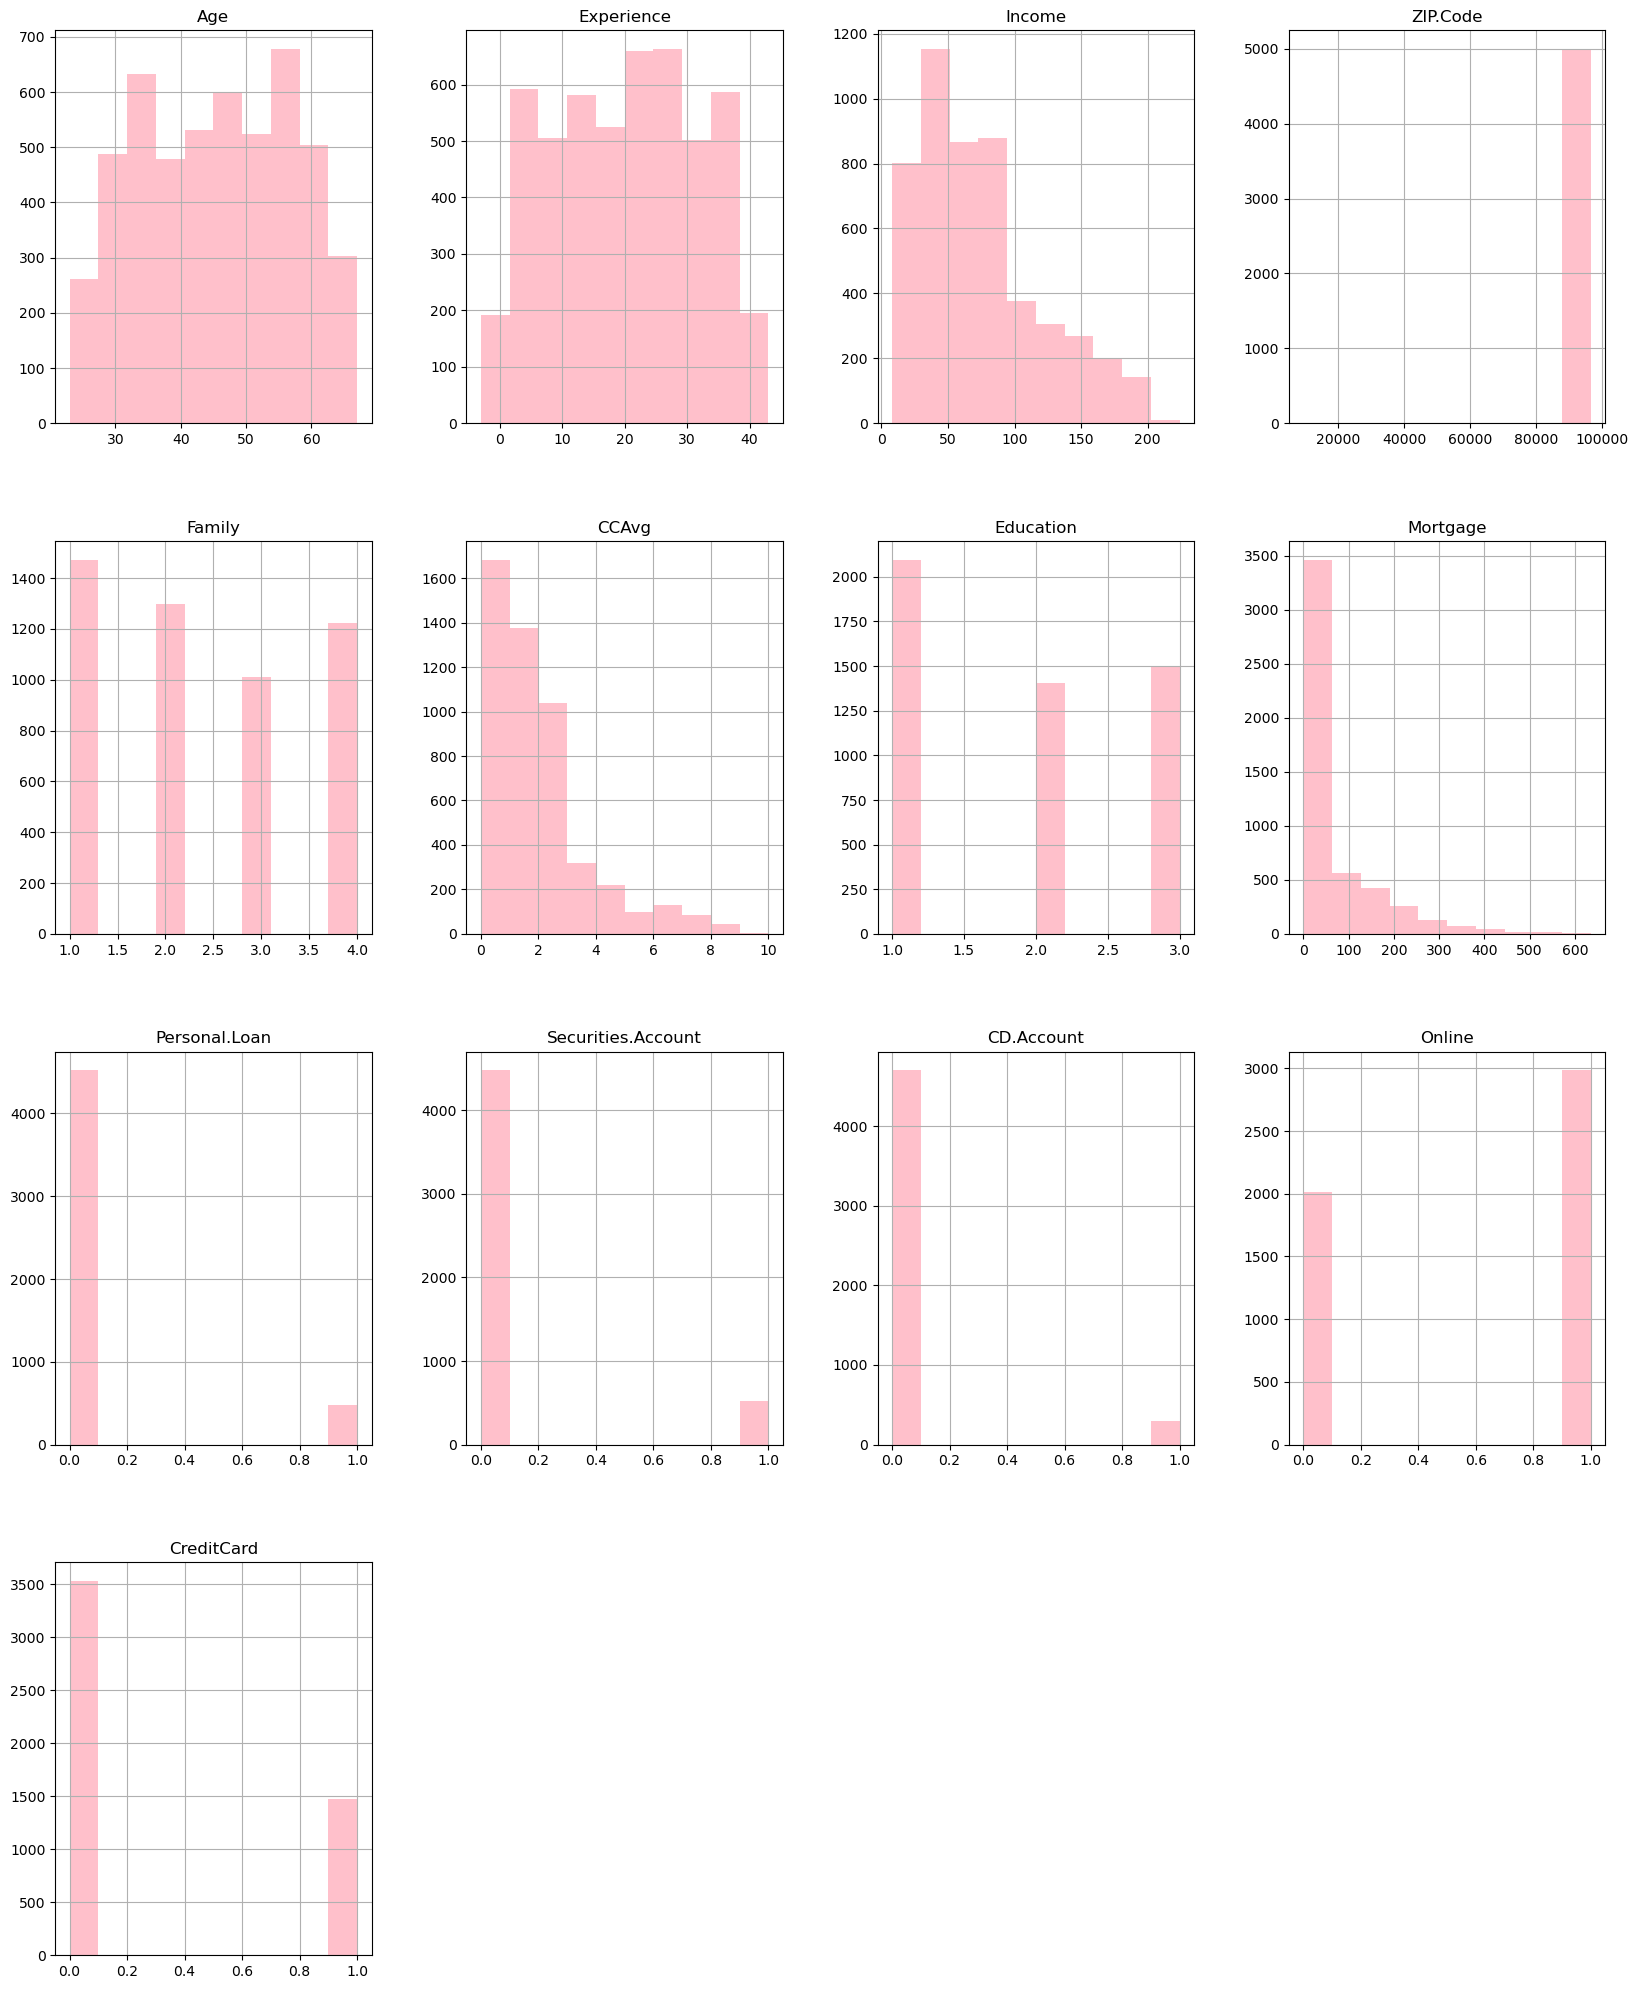

In [136]:
import matplotlib.pyplot as plt
df.hist(figsize=(20,25),color='pink')
plt.show()

In [138]:
X = df.drop('Personal.Loan',axis='columns')
X.head()

Age  Experience  Income  ZIP.Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Securities.Account  CD.Account  Online  CreditCard  
0                   1           0       0           0  
1                   1           0       0           0  
2                   0           0       0           0  
3                   0           0       0           0  
4                   0           0       0           1

In [139]:
y = df['Personal.Loan']
y

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Personal.Loan, Length: 5000, dtype: int64

In [140]:
from sklearn.model_selection import train_test_split

# Suponha que df seja o seu DataFrame e y seja a variável alvo
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Agora, X_train e y_train contêm 80% dos dados para treino
# X_val e y_val contêm 20% dos dados para validação


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
class Node:
    def __init__(self, is_leaf, weight=None, feature=None, threshold=None, left=None, right=None):
        self.is_leaf = is_leaf      # Booleano: True se for folha
        self.weight = weight        # Valor (peso) associado à folha
        self.feature = feature      # Nome da feature utilizada no split
        self.threshold = threshold  # Valor do limiar do split
        self.left = left            # Sub-árvore à esquerda
        self.right = right          # Sub-árvore à direita

In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_val)

In [142]:
X_train_scale.shape, X_test_scale.shape

((4000, 12), (1000, 12))

In [149]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Node:
    def __init__(self, is_leaf, weight=None, feature=None, threshold=None, left=None, right=None):
        self.is_leaf = is_leaf
        self.weight = weight
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

class XGBoostClassifier:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3, 
                 min_samples_split=10, reg_lambda=1, gamma=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.trees = []
        self.initial_prediction = 0

    def calculagradienteslogloss(self, y, pred):
        grad = pred - y
        hess = pred * (1 - pred)
        return grad, hess

    def fit(self, X, y):
        pos_rate = np.mean(y)
        self.initial_prediction = np.log(pos_rate / (1 - pos_rate + 1e-10))
        pred = np.full(y.shape, self.initial_prediction)
        
        for _ in range(self.n_estimators):
            prob = sigmoid(pred)
            grad, hess = self.calculagradienteslogloss(y, prob)
            tree = self.build_tree(X, grad, hess, profundidade=0)
            pred += self.learning_rate * self._predict_tree(tree, X)
            self.trees.append(tree)

    def melhor_split(self, X, grad, hess):
        num_features = X.shape[1]
        melhor_feature, melhor_threshold, melhor_ganho = None, None, -np.inf
        melhor_esq, melhor_dir = None, None
        
        for feature in range(num_features):
            valores_uni = np.unique(X[:, feature])
            if len(valores_uni) == 1:
                continue
            thresholds = (valores_uni[:-1] + valores_uni[1:]) / 2
            
            for threshold in thresholds:
                left_rule = X[:, feature] < threshold
                right_rule = ~left_rule
                
                if np.sum(left_rule) < self.min_samples_split or np.sum(right_rule) < self.min_samples_split:
                    continue
                
                G_left, H_left = np.sum(grad[left_rule]), np.sum(hess[left_rule])
                G_right, H_right = np.sum(grad[right_rule]), np.sum(hess[right_rule])
                G_total, H_total = np.sum(grad), np.sum(hess)
                
                ganho = 0.5 * (
                    (G_left**2 / (H_left + self.reg_lambda)) +
                    (G_right**2 / (H_right + self.reg_lambda)) -
                    (G_total**2 / (H_total + self.reg_lambda))
                ) - self.gamma
                
                if ganho > melhor_ganho:
                    melhor_feature = feature
                    melhor_threshold = threshold
                    melhor_esq = left_rule
                    melhor_dir = right_rule
                    melhor_ganho = ganho
        
        return melhor_feature, melhor_ganho, melhor_esq, melhor_dir, melhor_threshold

    def build_tree(self, X, grad, hess, profundidade=0):
        if profundidade >= self.max_depth or len(X) < self.min_samples_split:
            folha = -np.sum(grad) / (np.sum(hess) + self.reg_lambda)
            return Node(is_leaf=True, weight=folha)
        
        best_feature, ganho, esq, dir, threshold = self.melhor_split(X, grad, hess)
        
        if ganho == -np.inf or ganho <= 0:
            folha = -np.sum(grad) / (np.sum(hess) + self.reg_lambda)
            return Node(is_leaf=True, weight=folha)
        
        left_tree = self.build_tree(X[esq], grad[esq], hess[esq], profundidade + 1)
        right_tree = self.build_tree(X[dir], grad[dir], hess[dir], profundidade + 1)
        
        return Node(is_leaf=False, feature=best_feature, threshold=threshold, left=left_tree, right=right_tree)

    def predict_sample(self, tree, x):
        if tree.is_leaf:
            return tree.weight
        return self.predict_sample(tree.left, x) if x[tree.feature] < tree.threshold else self.predict_sample(tree.right, x)
    
    def _predict_tree(self, tree, X):
        return np.array([self.predict_sample(tree, x) for x in X])
    
    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.initial_prediction)
        for tree in self.trees:
            pred += self.learning_rate * self._predict_tree(tree, X)
        return sigmoid(pred)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.56).astype(int)


In [144]:
modelo = XGBoostClassifier(n_estimators=325, learning_rate=0.1, max_depth=6, min_samples_split=2)
modelo.fit(X_train_scale, y_train)
    
# Faz predições e mostra as probabilidades
probs = modelo.predict_proba(X_test_scale)
preds = modelo.predict(X_test_scale)
    
print("Probabilidades preditas:", probs)
print("Predições finais:", preds)

Probabilidades preditas: [9.20755963e-06 9.99438177e-01 9.53197274e-05 4.80389339e-06
 8.68171741e-06 1.15068497e-04 5.82550033e-05 5.05549949e-05
 7.50617555e-06 9.44715471e-05 7.36612522e-06 2.02311881e-05
 8.99563353e-05 1.36507444e-05 2.41790181e-04 6.89668864e-05
 3.82485293e-05 1.50110446e-04 2.95238820e-05 9.99851802e-01
 5.24883082e-06 8.76576625e-05 1.18390343e-04 1.14687035e-05
 3.00919742e-06 1.70730033e-06 8.64348122e-06 1.15244904e-04
 3.49981168e-04 1.62050026e-02 4.83338514e-04 4.97698960e-05
 9.99945419e-01 8.26257713e-03 2.42697298e-05 8.45814825e-06
 1.67944074e-06 6.23657324e-06 3.28344262e-06 1.87764354e-05
 1.55851919e-05 4.18836444e-05 9.97133661e-01 4.74211346e-05
 5.87532506e-06 2.88920580e-05 6.05733849e-05 1.60965815e-04
 3.43894904e-03 5.84572928e-06 1.94581286e-05 9.99664297e-01
 3.58432293e-05 5.93852750e-05 1.29625749e-04 1.96595734e-05
 1.16968203e-05 7.90719880e-06 1.86177954e-05 7.55612549e-05
 1.84692819e-04 9.83636902e-06 6.75265304e-06 1.66523142e-05

In [145]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_val, preds)
print(f"Erro Médio Absoluto (MAE): {mae:.4f}")

Erro Médio Absoluto (MAE): 0.0080


In [146]:
from sklearn.metrics import log_loss

erro_logloss = log_loss(y_val, probs)
print(f"Log Loss: {erro_logloss:.4f}")


Log Loss: 0.0260


In [147]:
from sklearn.metrics import accuracy_score

acuracia = accuracy_score(y_val, preds)
print(f"Acurácia: {acuracia:.4f}")


Acurácia: 0.9920


In [148]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Defina os parâmetros para a busca
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Criar o modelo XGBClassifier
xg_clf = XGBClassifier(min_child_weight=1)

# Inicialize o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_clf, param_distributions=params, 
                                   n_iter=10, cv=3, verbose=2, 
                                   n_jobs=-1, random_state=42)

# Ajuste o modelo aos seus dados de treinamento
random_search.fit(X_train, y_train)

# Exibir o melhor conjunto de hiperparâmetros
print("Melhores parâmetros encontrados:", random_search.best_params_)

# Avaliar o modelo
best_model = random_search.best_estimator_
accuracy = best_model.score(X_val, y_val)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Acurácia no conjunto de teste: 0.9880
